__More Ray Tracing__

In this example, we'll reinforce what we learnt about ray-tracing in the last tutorial and introduce the following new concepts:

1) Short-hand notation for setting up profiles and galaxies, to make code cleaner and easier to read.

2) That a tracer can be given any number of galaxies.

3) That by specifying redshifts and a cosmology, our results are converted to physical units of kiloparsecs (kpc).

In [ ]:
%matplotlib inline

from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.model.galaxy import galaxy as g
from autolens.lens import ray_tracing
from autolens.data.array import grids
from autolens.model.galaxy.plotters import galaxy_plotters
from autolens.lens.plotters import plane_plotters
from autolens.lens.plotters import ray_tracing_plotters

from astropy import cosmology

To begin, lets setup the grids we 'll ray-trace using. Lets do something crazy, and use a higher resolution grid then before and set the sub grid size to 4x4 per pixel!

Every regular-pixel is sub-gridded by 4x4, so the sub-grid has x16 more coordinates.

In [2]:
image_plane_grid_stack = grids.GridStack.from_shape_pixel_scale_and_sub_grid_size(shape=(200, 200), pixel_scale=0.025,
                                                                      sub_grid_size=4)
print(image_plane_grid_stack.regular.shape)
print(image_plane_grid_stack.sub.shape)

(40000, 2)
(640000, 2)


Next, lets setup a lens galaxy. In the previous tutorial, we set up each profile one line at a time. This made code long and cumbersome to read. This time we'll setup easy galaxy using one block of code. 
 
To help us, we've imported the 'light_profiles' and 'mass_profiles' modules as 'lp' and 'mp', and the 'galaxy' module as 'g'.

We'll also give the lens galaxy some attributes we didn't in the last tutorial:

1) A light-profile, meaning its light will appear in the image-plane image.

2) An external shear, which accounts for the deflection of light due to line-of-sight structures.

3) A redshift, which the tracer will use to convert arc second coordinates to kpc.

In [3]:
lens_galaxy = g.Galaxy(light=lp.SphericalSersic(centre=(0.0, 0.0), intensity=2.0, effective_radius=0.5, 
                                                sersic_index=2.5),
                       mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), axis_ratio=0.8, phi=90.0, einstein_radius=1.6),
                       shear=mp.ExternalShear(magnitude=0.05, phi=45.0),
                       redshift=0.5)
print(lens_galaxy)

Redshift: 0.5
Light Profiles:
SphericalSersic
centre: (0.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 2.0
effective_radius: 0.5
sersic_index: 2.5
Mass Profiles:
EllipticalIsothermal
centre: (0.0, 0.0)
axis_ratio: 0.8
phi: 90.0
einstein_radius: 1.6
slope: 2.0
core_radius: 0.0
ExternalShear
centre: (0.0, 0.0)
axis_ratio: 1.0
phi: 45.0
magnitude: 0.05


Lets also create a small satellite galaxy nearby the lens galaxy and at the same redshift.

In [4]:
lens_satellite = g.Galaxy(light=lp.SphericalDevVaucouleurs(centre=(1.0, 0.0), intensity=2.0, effective_radius=0.2),
                          mass=mp.SphericalIsothermal(centre=(1.0, 0.0), einstein_radius=0.4),
                          redshift=0.5)
print(lens_satellite)


Redshift: 0.5
Light Profiles:
SphericalDevVaucouleurs
centre: (1.0, 0.0)
axis_ratio: 1.0
phi: 0.0
intensity: 2.0
effective_radius: 0.2
sersic_index: 4.0
Mass Profiles:
SphericalIsothermal
centre: (1.0, 0.0)
axis_ratio: 1.0
phi: 0.0
einstein_radius: 0.4
slope: 2.0
core_radius: 0.0


Lets have a quick look at the appearance of our lens galaxy and its satellite.

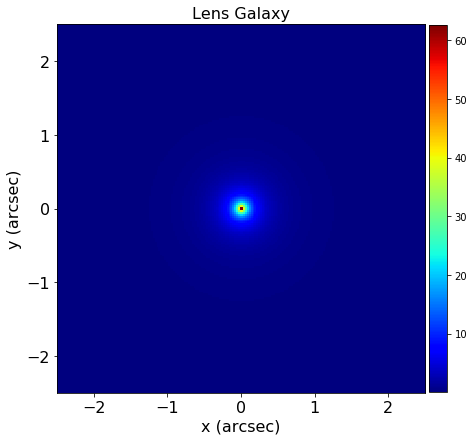

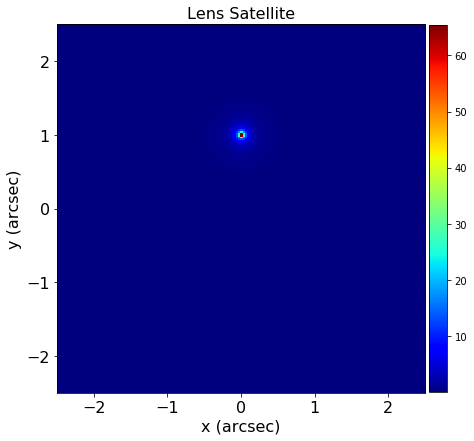

In [5]:
galaxy_plotters.plot_intensities(galaxy=lens_galaxy, grid=image_plane_grid_stack.regular, title='Lens Galaxy')
galaxy_plotters.plot_intensities(galaxy=lens_satellite, grid=image_plane_grid_stack.regular, title='Lens Satellite')

And their deflection angles - note that the satellite doesn't contribute as much to the deflections.

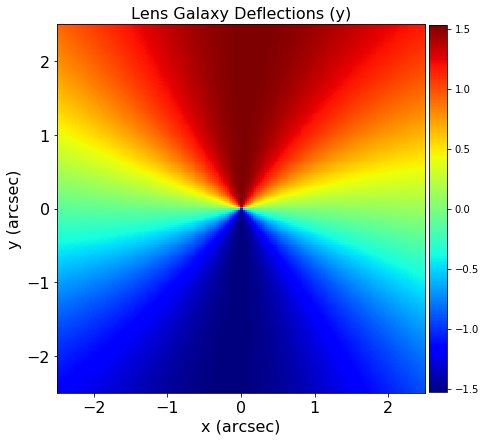

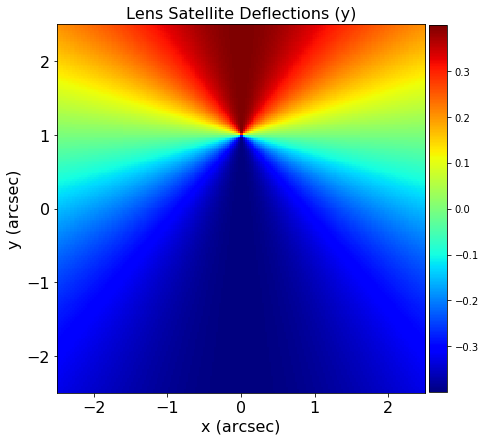

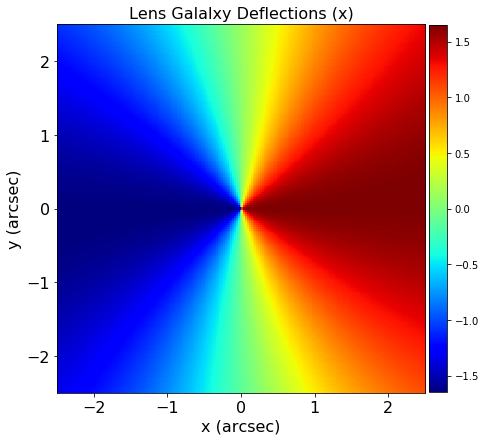

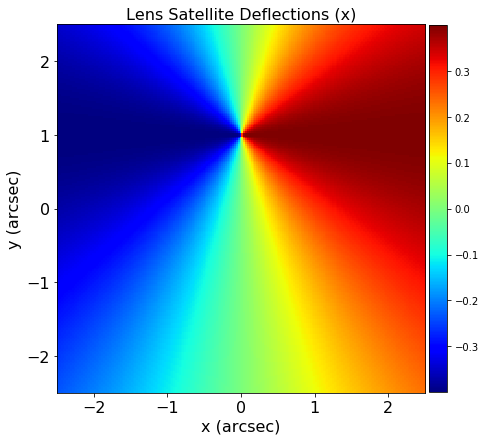

In [6]:
galaxy_plotters.plot_deflections_y(galaxy=lens_galaxy, grid=image_plane_grid_stack.regular, title='Lens Galaxy Deflections (y)')
galaxy_plotters.plot_deflections_y(galaxy=lens_satellite, grid=image_plane_grid_stack.regular, title='Lens Satellite Deflections (y)')
galaxy_plotters.plot_deflections_x(galaxy=lens_galaxy, grid=image_plane_grid_stack.regular, title='Lens Galalxy Deflections (x)')
galaxy_plotters.plot_deflections_x(galaxy=lens_satellite, grid=image_plane_grid_stack.regular, title='Lens Satellite Deflections (x)')


Now, lets make two source galaxies at redshift 1.0. Lets not use the terms 'light' and 'mass' to setup the light and mass profiles. Instead, lets use more descriptive names of what we think each component represents ( e.g. a 'bulge' and 'disk').

In [7]:
source_galaxy_0 = g.Galaxy(bulge=lp.SphericalDevVaucouleurs(centre=(0.1, 0.2), intensity=0.3, effective_radius=0.3),
                           disk=lp.EllipticalExponential(centre=(0.1, 0.2), axis_ratio=0.8, phi=45.0, intensity=3.0,
                                                       effective_radius=2.0),
                           redshift=1.0)

source_galaxy_1 = g.Galaxy(disk=lp.EllipticalExponential(centre=(-0.3, -0.5), axis_ratio=0.6, phi=80.0, intensity=8.0,
                                                         effective_radius=1.0),
                           redshift=1.0)
print(source_galaxy_0)
print(source_galaxy_1)

Redshift: 1.0
Light Profiles:
SphericalDevVaucouleurs
centre: (0.1, 0.2)
axis_ratio: 1.0
phi: 0.0
intensity: 0.3
effective_radius: 0.3
sersic_index: 4.0
EllipticalExponential
centre: (0.1, 0.2)
axis_ratio: 0.8
phi: 45.0
intensity: 3.0
effective_radius: 2.0
sersic_index: 1.0
Redshift: 1.0
Light Profiles:
EllipticalExponential
centre: (-0.3, -0.5)
axis_ratio: 0.6
phi: 80.0
intensity: 8.0
effective_radius: 1.0
sersic_index: 1.0


Lets look at our source galaxies (before lensing)

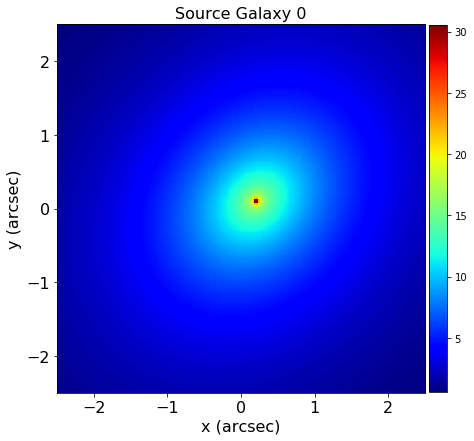

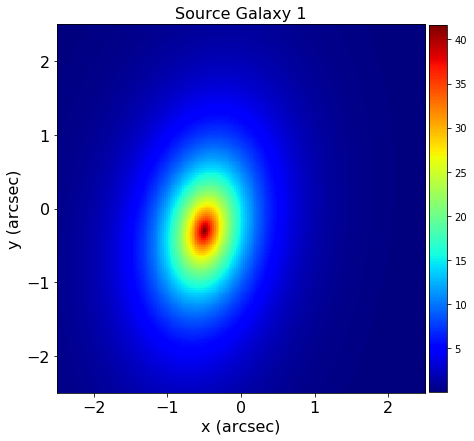

In [8]:
galaxy_plotters.plot_intensities(galaxy=source_galaxy_0, grid=image_plane_grid_stack.regular, title='Source Galaxy 0')
galaxy_plotters.plot_intensities(galaxy=source_galaxy_1, grid=image_plane_grid_stack.regular, title='Source Galaxy 1')

Now lets pass these our 4 galaxies to the ray_tracing module, which means the following will occur:

1) Using every mass-profile in each lens galaxy, the deflection angles are computed.

2) These deflection angles are summed, such that the deflection of light due to every mass-profile and both the lens galaxy and its satellite is computed. 

3) These deflection angles are used to trace every image-grid and sub-grid coordinate to a source-plane coordinate.

4) The light of all source galaxies is ray-traced back forward to form our image-plane image.

Note that we've also supplied the tracer below with a Planck15 cosmology.

In [9]:
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy, lens_satellite],
                                             source_galaxies=[source_galaxy_0, source_galaxy_1],
                                             image_plane_grid_stack=image_plane_grid_stack, 
                                             cosmology=cosmology.Planck15)

As we did previously, we can inspect each grid.

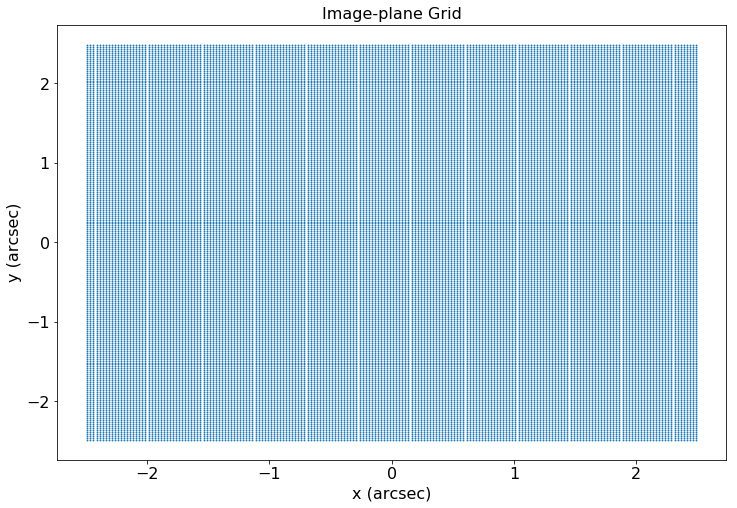

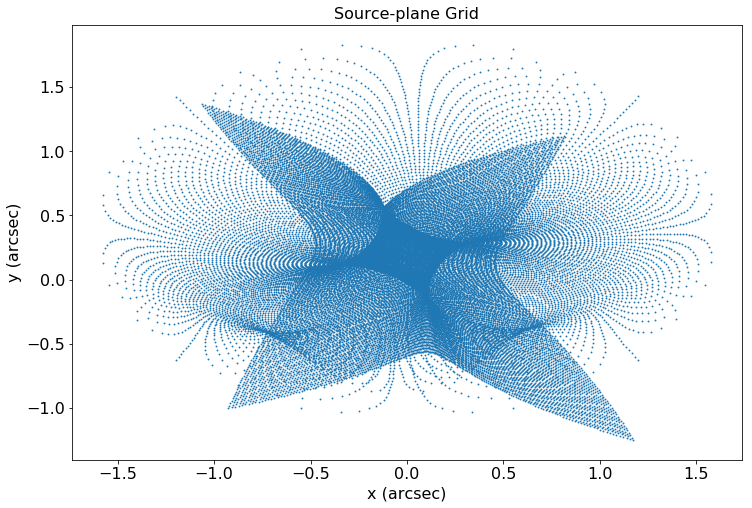

In [10]:
plane_plotters.plot_plane_grid(plane=tracer.image_plane, title='Image-plane Grid')
plane_plotters.plot_plane_grid(plane=tracer.source_plane, title='Source-plane Grid')

We can zoom in on the 'centre' of the source-plane.

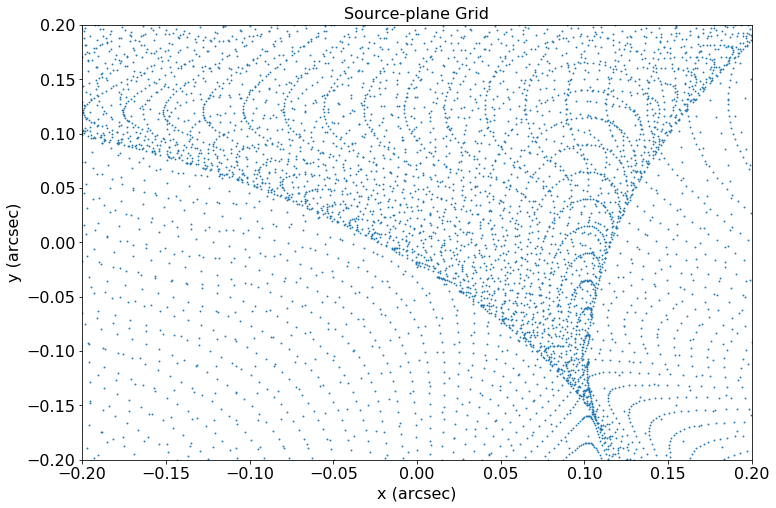

In [11]:
plane_plotters.plot_plane_grid(plane=tracer.source_plane, axis_limits=[-0.2, 0.2, -0.2, 0.2], title='Source-plane Grid')

Lets plot the lensing quantities again. Note that, because we supplied our galaxies with redshifts and our tracer with a cosmology, our units have been converted to kiloparsecs! (This cell can take a bit of time to run)

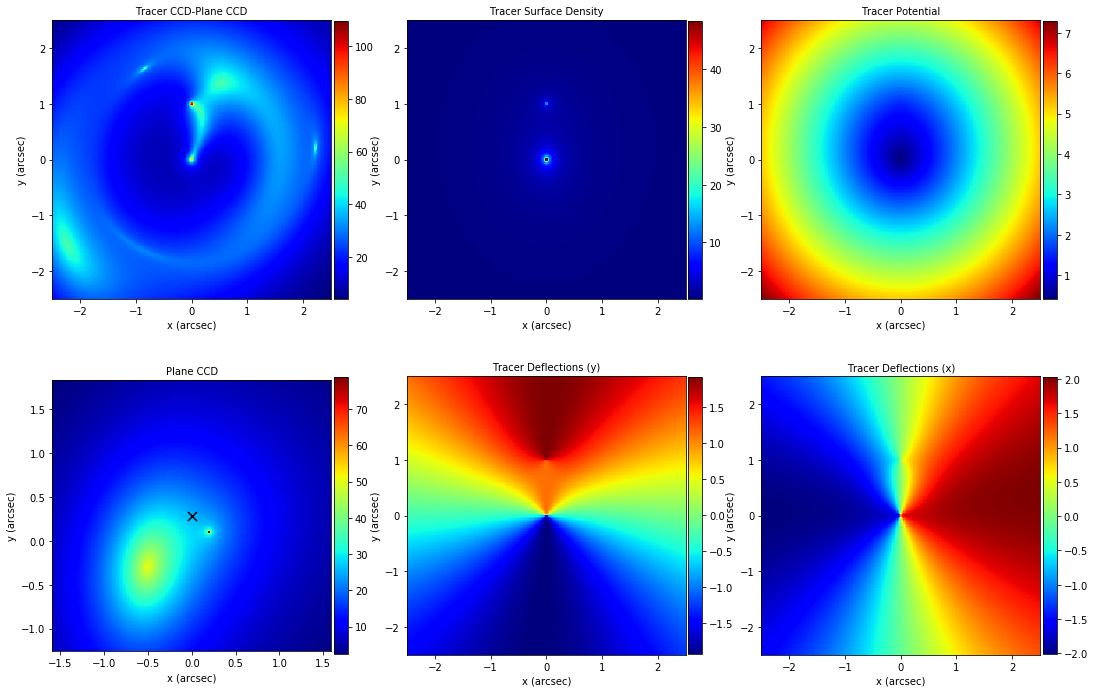

In [12]:
ray_tracing_plotters.plot_ray_tracing_subplot(tracer=tracer)

In the previous example, we saw that the tracer had attributes we plotted (e.g. surface density, potential, etc.). Now we've input a cosmology and galaxy redshifts, the tracer has attributes associated with its cosmology.

In [13]:
print('Image-plane arcsec-per-kpc:')
print(tracer.image_plane.arcsec_per_kpc_proper)
print('Image-plane kpc-per-arcsec:')
print(tracer.image_plane.kpc_per_arcsec_proper)
print('Angular Diameter Distance to Image-plane:')
print(tracer.image_plane.angular_diameter_distance_to_earth)

print('Source-plane arcsec-per-kpc:')
print(tracer.source_plane.arcsec_per_kpc_proper)
print('Source-plane kpc-per-arcsec:')
print(tracer.source_plane.kpc_per_arcsec_proper)
print('Angular Diameter Distance to Source-plane:')
print(tracer.source_plane.angular_diameter_distance_to_earth)

print('Angular Diameter Distance From Image To Source Plane:')
print(tracer.angular_diameter_distance_from_image_to_source_plane)
print('Lensing Critical Surface Density:')
print(tracer.critical_density_kpc)

Image-plane arcsec-per-kpc:
0.15902722256138194
Image-plane kpc-per-arcsec:
6.288231561197116
Angular Diameter Distance to Image-plane:
1297040.8646071993
Source-plane arcsec-per-kpc:
0.12147853425766525
Source-plane kpc-per-arcsec:
8.231907028767104
Angular Diameter Distance to Source-plane:
1697952.7083327575
Angular Diameter Distance From Image To Source Plane:
725172.0598773579
Lensing Critical Surface Density:
3001935253.5346775


And with that, we've completed tutorial 6. Try the following:

1) By changing the lens and source galaxy redshifts, does the image-plane image of the tracer change at all?

2) What happens to the cosmological quantities as you change these redshifts? Do you remember enough of your cosmology lectures to predict how quantities like the angular diameter distance change as a function of redshift?

3) The tracer has a small delay in being computed, whereas other tracers were almost instant. What do you think is the cause of this slow-down?